Notebook with toy example to test/demonstrate bayesian hierarchical clustering

/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [85.0, 85.0, 95.0, 95.0],
  [60.0, 60.0, 90.0, 90.0],
  [20.0, 20.0, 75.0, 75.0]],
 'dcoord': [[0.0, 91154.22223733149, 91154.22223733149, 0.0],
  [0.0, 43926.37938857273, 43926.37938857273, 0.0],
  [91154.22223733149,
   224004.08931264124,
   224004.08931264124,
   43926.37938857273],
  [0.0, 55429.23216472719, 55429.23216472719, 0.0],
  [0.0, 61572.179215831115, 61572.179215831115, 0.0],
  [55429.23216472719,
   207373.99632807393,
   207373.99632807393,
   61572.179215831115],
  [0.0, 87360.0822002614, 87360.0822002614, 0.0],
  [207373.99632807393, 393079.1541864936, 393079.1541864936, 87360.0822002614],
  [224004.08931264124, 784713.04219068, 784713.04219068, 393079.1541864936]],
 'ivl': ['cl1_cell0',
  'cl1_cell1',
  'cl2_cell3',
  'cl2_cell4',
  'cl1_cell2',
  'cl2_cell1',
  'cl1_cell3',
  'cl2_cell0',
 

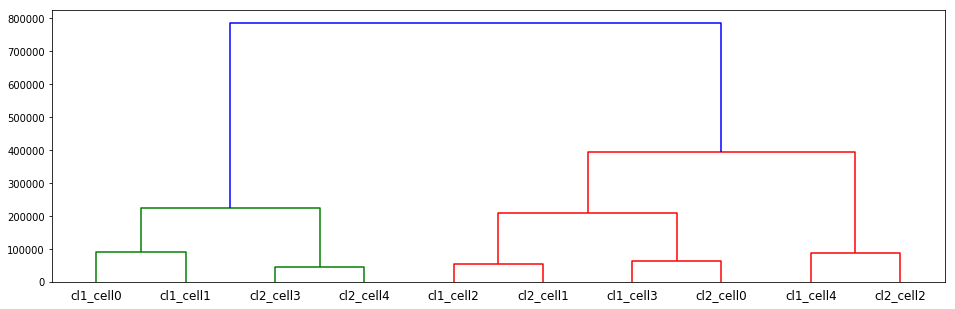

In [12]:
import scgenome.simulation as sim
import numpy as np
import pandas as pd
from IPython.display import display
from scgenome import cncluster
from scgenome.utils import cn_mat_to_cn_data, cn_mat_as_df
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

NUM_SAMPLE = 5
NUM_BIN = 1000
CHR_NAMES = ["1","2"]
max_cn = 7

cluster1 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=1., jump_lambda=0.5, seed=None, max_cn=max_cn)
cluster2 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=3., jump_lambda=0.1, seed=None, max_cn=max_cn)

clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

cn_mat = np.concatenate([cluster1, cluster2])
cell_ids = clst1_cell_ids + clst2_cell_ids

df_cn_mat = cn_mat_as_df(cn_mat,CHR_NAMES)
cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

tlinkage, root, cell_ids = cncluster.bayesian_cluster(cn_data, n_states=max_cn, value_ids=["copy"])

plinkage = tlinkage[["i","j","r_merge","merge_count"]]
plinkage["r_merge"] = plinkage["r_merge"].astype("float")
plinkage["dist"] = -1 * plinkage["r_merge"]
plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")

fig = plt.figure(figsize=(16, 5))
dendrogram(plot_data, labels=cell_ids)

In [3]:
cell_ids

cell_id
cl1_cell0    cl1_cell0
cl1_cell1    cl1_cell1
cl1_cell2    cl1_cell2
cl1_cell3    cl1_cell3
cl1_cell4    cl1_cell4
cl2_cell0    cl2_cell0
cl2_cell1    cl2_cell1
cl2_cell2    cl2_cell2
cl2_cell3    cl2_cell3
cl2_cell4    cl2_cell4
Name: cell_id, dtype: object